# Part 2: Fundamental Matrix Estimation, Camera Calibration, Triangulation

## Fundamental Matrix Estimation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


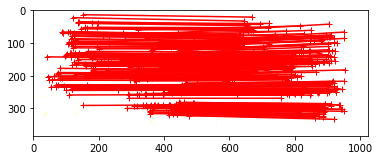

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


residual of method: 0.2889731310524968


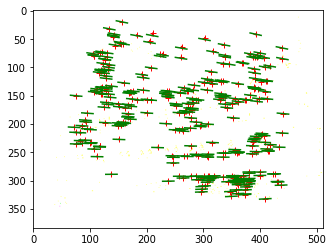

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


residual of method: 0.017023341947759944


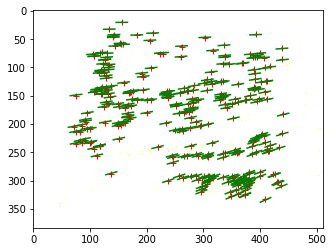

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
##
## load images and match files for the first example
##

I1 = Image.open('library1.jpg');
I2 = Image.open('library2.jpg');
matches = np.loadtxt('library_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3).astype(float))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()

##
## display second image with epipolar lines reprojected 
## from the first image
##

def fit_fundamental(matches, normalize = True):     
    p1 = matches[:, 0:2]
    p2 = matches[:, 2:4]

    if normalize:
        p1, T1 = normalization(p1)
        p2, T2 = normalization(p2)

    # eight random points from both images to compute algorithm
    rand_idx = random.sample(range(p1.shape[0]), k=8)
    select8_p1 = p1[rand_idx]
    select8_p2 = p2[rand_idx]

    A = []
    for i in range(select8_p1.shape[0]):
        p1 = select8_p1[i]
        p2 = select8_p2[i]
        
        row = [p2[0]*p1[0], p2[0]*p1[1], p2[0], p2[1]*p1[0], p2[1]*p1[1], p2[1], p1[0], p1[1], 1]
        A.append(row)

    A = np.array(A)

    U, s, V = np.linalg.svd(A)
    # smallest singular value
    F = V[len(V)-1].reshape(3, 3)
    # normalize F
    F = F / F[2, 2] 

    # Enforcing rank-2 constraint
    U, s, v = np.linalg.svd(F)
    # Vector(s) with the singular values, within each vector sorted in descending order
    s_discard = np.diag(s)
    # discarding the smallest value
    s_discard[-1] = 0
    F = np.dot(U, np.dot(s_discard, v))

    # transform F back to original units
    if normalize:
        F = np.dot(np.dot(T2.T, F), T1)
    
    residual = calculate_residual(matches, F)
    print('residual of method: ' + str(residual))
    return F

def normalization(pts):
  # Centering done by subtracting mean from all points
  mean = np.mean(pts, axis=0)
  x_center = pts[:, 0] - mean[0]
  y_center = pts[:, 1] - mean[1]

  #Scale so the mean squared distance between origin and data point is 2
  scale = np.sqrt(1 / (2 * len(pts)) * np.sum(x_center**2 + y_center**2))
  scale = 1 / scale

  transform = np.array([[scale, 0, -scale*mean[0]], [0, scale, -scale*mean[1]], [0, 0, 1]])
  
  pts = np.concatenate((pts, np.ones((pts.shape[0], 1))), axis=1)
  normalized = np.dot(transform, pts.T).T

  return normalized[:, 0:2], transform

def calculate_residual(matches, F):
    p1 = matches[:, 0:2]
    p2 = matches[:, 2:4]
    p1_homo = np.concatenate((p1, np.ones((p1.shape[0], 1))), axis=1)
    p2_homo = np.concatenate((p2, np.ones((p2.shape[0], 1))), axis=1)

    residual = 0
    for i in range(p1.shape[0]):
        residual += abs(np.dot(np.dot(p2_homo[i], F), p1_homo[i].T))

    residual = residual / matches.shape[0]
    return residual


##
# for normalized algorithm
##


# first, fit fundamental matrix to the matches
F = fit_fundamental(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype(float))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()


##
# for unnormalized algorithm
##


# first, fit fundamental matrix to the matches
F = fit_fundamental(matches, normalize = False); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype(float))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

In [1]:
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
!pip install opencv-contrib-python==3.4.2.17 

     |████████████████████████████████| 30.6 MB 27 kB/s 


## Camera Calibration

In [6]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [49]:
import cv2
import scipy
from scipy.spatial import distance

def calibrate(points_2d, points_3d):
    A_1 = []
    A_2 = []
    img1_2d = points_2d[:, 0:2]
    img2_2d = points_2d[:, 2:4]

    for i in range(points_2d.shape[0]):
        
        row11 = [0, 0, 0, 0, points_3d[i, 0], points_3d[i, 1], points_3d[i, 2], 1, -img1_2d[i, 1]*points_3d[i, 0], -img1_2d[i, 1]*points_3d[i, 1], -img1_2d[i, 1]*points_3d[i, 2], -img1_2d[i, 1]]
        row12 = [points_3d[i, 0], points_3d[i, 1], points_3d[i, 2], 1, 0, 0, 0, 0, -img1_2d[i, 0]*points_3d[i, 0], -img1_2d[i, 0]*points_3d[i, 1], -img1_2d[i, 0]*points_3d[i, 2], -img1_2d[i, 0]]

        row21 = [0, 0, 0, 0, points_3d[i, 0], points_3d[i, 1], points_3d[i, 2], 1, -img2_2d[i, 1]*points_3d[i, 0], -img2_2d[i, 1]*points_3d[i, 1], -img2_2d[i, 1]*points_3d[i, 2], -img2_2d[i, 1]]
        row22 = [points_3d[i, 0], points_3d[i, 1], points_3d[i, 2], 1, 0, 0, 0, 0, -img2_2d[i, 0]*points_3d[i, 0], -img2_2d[i, 0]*points_3d[i, 1], -img2_2d[i, 0]*points_3d[i, 2], -img2_2d[i, 0]]


        A_1.append(row11)
        A_1.append(row12)

        A_2.append(row21)
        A_2.append(row22)

    A_1 = np.array(A_1)
    A_2 = np.array(A_2)

    U, s, V = np.linalg.svd(A_1)
    P1 = V[len(V)-1].reshape(3, 4)

    U, s, V = np.linalg.svd(A_2)
    P2 = V[len(V)-1].reshape(3, 4)

    return P1, P2

def calibration_residual(matches, proj_mat):
    print(matches.shape, proj_mat.shape)
    num_pairs = len(matches)

    p1 = np.concatenate((matches[:, 0:2], np.ones((1, num_pairs)).T), axis=1)
    print(p1)
    p2 = matches[:, 2:4]

    transform_p1 = np.zeros((num_pairs, 2))

    for i in range(num_pairs):
        transform_p1[i] = (np.matmul(proj_mat.T, p1[i]) / np.matmul(proj_mat.T, p1[i])[-1])[0:2]

    errors = np.square(np.linalg.norm(p2 - transform_p1, axis=1))

    return errors

lab_3d = np.loadtxt('lab_3d.txt')
lab_2d = np.loadtxt('lab_matches.txt')
# print(lab_2d.shape)
# print(lab_2d)
# print(lab_2d[:, 0:2][0, 1])
# print(lab_3d.shape)
# print(lab_3d)

cam1_lab, cam2_lab = calibrate(lab_2d, lab_3d)
print("Camera 1 projection matrix:\n", cam1_lab)
print("Camera 2 projection matrix:\n", cam2_lab)
points_3d_proj, residual = evaluate_points(camera2, lab_2d, lab_3d)
print("Residual between projected and observed 2D points: ", residual)

Camera 1 projection matrix:
 [[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]]
Camera 2 projection matrix:
 [[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
Residual between projected and observed 2D points:  3078.5011553337563


## Triangulation and Camera Centers

In [44]:
import mpl_toolkits.mplot3d.axes3d as p3

def triangulate(P1, P2, matches):
    # Don't know why needs to transpose V, but it just works..
    U, s, V = np.linalg.svd(P1)
    center1 = V.T[:, -1]
    center1 = center1/center1[-1]
    
    U, s, V = np.linalg.svd(P2)
    center2 = V.T[:, -1]
    center2 = center2/center2[-1]
    
    ones = np.ones((matches.shape[0], 1))
    points1 = np.concatenate((matches[:, 0:2], ones), axis=1)
    points2 = np.concatenate((matches[:, 2:4], ones), axis=1) 

    X_3d = np.zeros((matches.shape[0], 4))
    for i in range(matches.shape[0]):
        x1_cross_P1 = np.array([[0, -points1[i,2], points1[i,1]], 
                          [points1[i,2], 0, -points1[i,0]], 
                          [-points1[i,1], points1[i,0], 0]])
        x2_cross_P2 = np.array([[0, -points2[i,2], points2[i,1]], 
                          [points2[i,2], 0, -points2[i,0]], 
                          [-points2[i,1], points2[i,0], 0]])

        x_cross_P = np.concatenate((x1_cross_P1.dot(P1), x2_cross_P2.dot(P2)), 
                                   axis=0)
        
        U, s, V = np.linalg.svd(x_cross_P)
        temp_3d = V.T[:, -1]
        temp_3d = temp_3d / temp_3d[-1]
        X_3d[i] = temp_3d

    return center1, center2, X_3d


def calculate_residual_triangulation(P1, P2, X_3d, matches):
    # Project 3D points back to 2D and convert to homogeneous.
    projected1 = np.dot(P1, X_3d.T).T
    projected1 = projected1 / projected1[:, -1][:, np.newaxis]
    projected2 = np.dot(P2, X_3d.T).T
    projected2 = projected2 / projected2[:, -1][:, np.newaxis]
    # Compute residual.
    res1 = np.linalg.norm(projected1[:, 0:2]-matches[:, 0:2]) ** 2
    res2 = np.linalg.norm(projected2[:, 0:2]-matches[:, 2:4]) ** 2
    # avg_res = (res1 + res2) / 2 / matches.shape[0]

    avg_res1 = res1 / matches.shape[0]
    avg_res2 = res2 / matches.shape[0]
    
    return avg_res1, avg_res2


def plot_3d(center1, center2, X_3d):
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    
    ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c='b', marker='o', alpha=0.6)
    ax.scatter(center1[0], center1[1], center1[2], c='r', marker='+')
    ax.scatter(center2[0], center2[1], center2[2], c='g', marker='+')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

Avg residuals for library: 391853.42184145143, 321882.2533743872


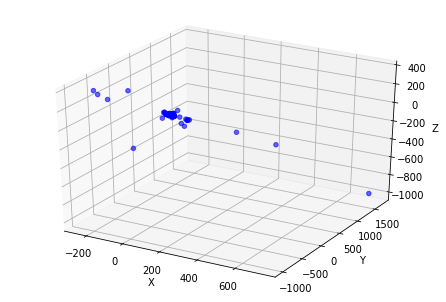

Avg residuals for lab: 2.012517871437338, 0.05112474041721978


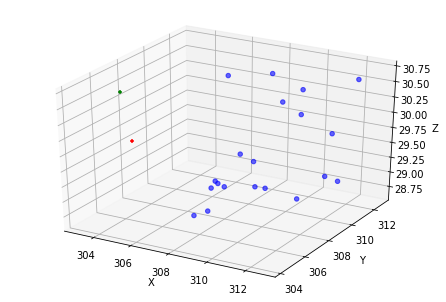

In [48]:
cam1_lib = np.loadtxt('library1_camera.txt')
cam2_lib = np.loadtxt('library2_camera.txt')
lab_matches = np.loadtxt('lab_matches.txt')
# Triangulation.
center1_lib, center2_lib, X_3D_lib = triangulate(cam1_lib, cam2_lib, matches)
avg_res1_lib, avg_res2_lib = calculate_residual_triangulation(cam1_lib, cam2_lib, X_3D_lib, matches)

center1_lab, center2_lab, X_3D_lab = triangulate(cam1_lab, cam2_lab, lab_matches)
avg_res1_lab, avg_res2_lab = calculate_residual_triangulation(cam1_lab, cam2_lab, X_3D_lab, lab_matches)

print("Avg residuals for library: {}, {}".format(avg_res1_lib, avg_res2_lib))
plot_3d(center1_lib, center2_lib, X_3D_lib)

print("Avg residuals for lab: {}, {}".format(avg_res1_lab, avg_res2_lab))
plot_3d(center1_lab, center2_lab, X_3D_lab)

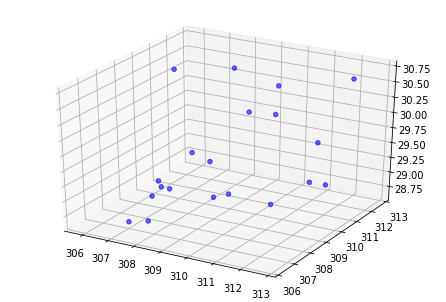

In [9]:
lab_3d = np.loadtxt('lab_3d.txt') 
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(lab_3d[:,0], lab_3d[:,1], lab_3d[:,2], c='b', marker='o', alpha=0.6)
plt.show()